In [1]:
from econml.grf import CausalForest, CausalIVForest, RegressionForest
from econml.dml import CausalForestDML
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import pandas as pd
import psutil
from toolz import curry
## Ignore warnings
import warnings
warnings.filterwarnings("ignore")
# Main imports
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML

# Helper imports
import numpy as np
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
def demean(df, group_vars, vars_to_demean):
    """
    Demean variables by group variables (fixed effects).
    
    Args:
        df (pd.DataFrame): The dataframe containing the data.
        group_vars (list of str): List of column names representing the fixed effect variables.
        vars_to_demean (list of str): List of variables to demean.
        
    Returns:
        df_demeaned (pd.DataFrame): DataFrame with demeaned variables.
    """
    df_demeaned = df.copy()
    
    # Group by the fixed effect variables and calculate group means
    group_means = df.groupby(group_vars, observed=True)[vars_to_demean].transform('mean')
    
    # Subtract the group means from the original variables to demean
    df_demeaned[vars_to_demean] = df[vars_to_demean] - group_means
    
    return df_demeaned

In [3]:
@curry
def elast(data, y, t):
    return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [4]:
# Get the virtual memory details
memory_info = psutil.virtual_memory()
total_memory = memory_info.total
available_memory = memory_info.available
used_memory = memory_info.used

print(f"Total Memory: {total_memory / (1024 ** 3):.2f} GB")
print(f"Available Memory: {available_memory / (1024 ** 3):.2f} GB")
print(f"Used Memory: {used_memory / (1024 ** 3):.2f} GB")

Total Memory: 7.45 GB
Available Memory: 0.33 GB
Used Memory: 7.13 GB


In [5]:
df = pd.read_csv("./Final Data/analysis_input3.csv")
df = df.dropna(subset=['overlap']).dropna()

In [6]:
df['branch_closures_tract_binary'] = [1 if x>0 else 0 for x in df['branch_closures_tract'] ]

In [7]:
# Step 2: Create event_year variable
df['event_year'] = df['year'] - df['EFFDATE']

# Step 3: Preserve, then generate close_2yr
df['close_2yr'] = 0
df.loc[((df['event_year'] == 0) | (df['event_year'] == 1)), 'close_2yr'] = df['branch_closures_tract_binary'] #(df['event_year'] == 0) | 

# Collapse (taking max of 'close_2yr') and group by relevant columns
df_collapsed = df.groupby(['state', 'county', 'tract', 'overlap', 'mergerID']).agg({'close_2yr': 'max'}).reset_index()
tempclose2 = df_collapsed.copy()
# Merge the collapsed dataframe back into the original one
df.drop(columns=['close_2yr'], inplace=True)
df = df.merge(tempclose2, on=['state', 'county', 'tract', 'overlap', 'mergerID'], how='left')

In [8]:
# Step 4: Generate POST, POST_close, and POST_expose variables
df['POST'] = (df['event_year'] > 0).astype(int)
df['POST_close'] = df['POST'] * df['close_2yr']
df['POST_expose'] = df['POST'] * df['overlap']

# Step 4: Generate year dummies (ydum1999 to ydum2013)
for year in range(2010, 2023):
    df[f'ydum{year}'] = (df['year'] == year).astype(int)
    
# Step 5: Interact control variables with year dummies
control_vars = ['poptot', 'popden', 'pminority', 'pcollege', 'medincome', 'total_branches_county', 'avg_branch_growth_county']


# Step 7: Create group variables
df['group_timeID'] = pd.Categorical(pd.factorize(df[['state', 'county', 'year']].apply(tuple, axis=1))[0])
df['indivID'] = pd.Categorical(pd.factorize(df[['state', 'county', 'tract']].apply(tuple, axis=1))[0])
df['clustID'] = pd.Categorical(pd.factorize(df[['state', 'county']].apply(tuple, axis=1))[0])

In [9]:
df_dowhy = df.dropna(subset = ['branch_closures_tract_binary', 'total_branches_tract', 'sbl_total', 'POST_close', 'POST_expose', 'avg_branch_growth_tract'] + control_vars)

In [10]:
y = df_dowhy["POST_close"] # POST_close
T = df_dowhy["POST_expose"]# POST_expose
X = df_dowhy[control_vars]

X_test = X.copy()
X_test['total_branches_county'] = X_test['total_branches_county']*0.1

## 1. Causal Forest: Heterogeneous causal effects with no unobserved confounders

In [11]:
np.random.seed(123)
n_treatments = 1

In [12]:
est = CausalForest(criterion='het', n_estimators=400, min_samples_leaf=5, max_depth=None,
                   min_var_fraction_leaf=None, min_var_leaf_on_val=True,
                   min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=0, n_jobs=-1, random_state=1235)

In [13]:
est.fit(X, T, y)

CausalForest(criterion='het', min_var_leaf_on_val=True, n_estimators=400,
             random_state=1235)

In [14]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

In [29]:
# Linear regression for the first plot
x = df_dowhy['pminority'].values.reshape(-1, 1)

y1 = point
model1 = LinearRegression().fit(x, y1)
line1 = model1.predict(x)

In [30]:
point = est.predict(X_test)

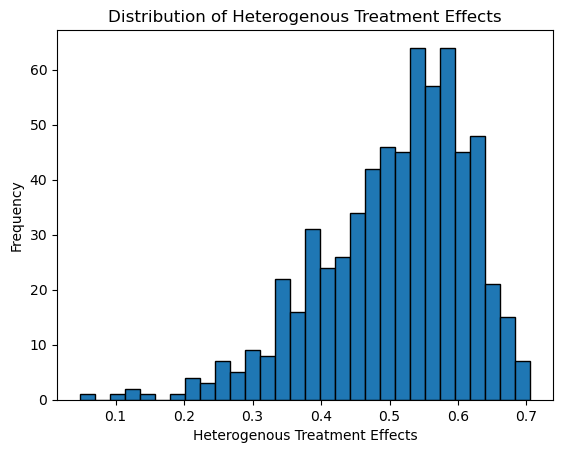

In [31]:
plt.hist(point, bins=30, edgecolor='black')  # Increase bins for smaller bin sizes
plt.title('Distribution of Heterogenous Treatment Effects')       # Add title
plt.xlabel('Heterogenous Treatment Effects')                         # Label x-axis
plt.ylabel('Frequency')                     # Label y-axis
plt.show()

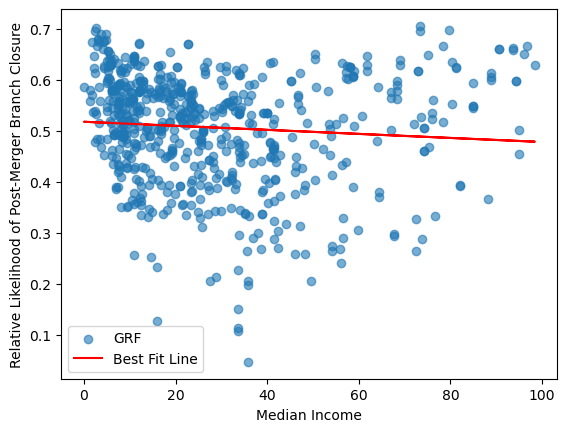

In [32]:
for t in range(n_treatments):
    plt.scatter(df_dowhy['pminority'], point[:, t], label='GRF', alpha=.6)
    plt.plot(df_dowhy['pminority'], line1, color='red', label='Best Fit Line')
    plt.xlabel('Median Income')
    plt.ylabel('Relative Likelihood of Post-Merger Branch Closure')
    plt.legend()
plt.show()

## 2. Causal IV Forest: Heterogeneous causal effects with unobserved confounders

In [34]:
y = df_dowhy["sbl_total"] # POST_close
T = df_dowhy["POST_close"]# POST_expose
Z = df_dowhy["POST_expose"]# POST_expose
X = df_dowhy[control_vars]

X_test = X.copy()
X_test['total_branches_county'] = X_test['total_branches_county']*0.1

In [35]:
est = CausalIVForest(criterion='mse', n_estimators=400, min_samples_leaf=40,
                     min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
                     min_impurity_decrease = 0.001, max_samples=.45, max_depth=None,
                     warm_start=False, inference=True, subforest_size=4,
                     honest=True, verbose=0, n_jobs=-1, random_state=123)

In [36]:
est.fit(X, T, y, Z=Z)

CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
               n_estimators=400, random_state=123)

In [37]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

In [38]:
# Linear regression for the second plot
y2 = point
model2 = LinearRegression().fit(x, y2)
line2 = model2.predict(x)

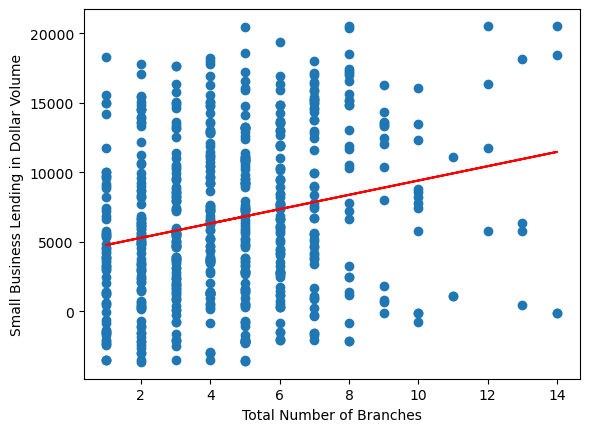

In [39]:
for t in range(n_treatments):
    plt.scatter(df_dowhy['total_branches_tract'], point[:, t])
    plt.plot(df_dowhy['total_branches_tract'], line2, color='red', label='Best Fit Line')
    plt.xlabel('Total Number of Branches')
    plt.ylabel('Small Business Lending in Dollar Volume')
plt.show()

## 3. Regression Forest: Random Forest Regressor with confidence intervals

In [24]:
np.random.seed(123)
n_samples = 2000
n_features = 10
n_outputs = 2
def true_te(X):
    return np.hstack([X[:, [0]] ** 2 + 1, np.ones((X.shape[0], n_outputs - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_outputs - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_outputs - 1))*np.arange(1, n_outputs).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
y = true_te(X) + 0.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [25]:
est = RegressionForest(n_estimators=400, min_samples_leaf=5, max_depth=None,
                       min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                       warm_start=False, inference=True, subforest_size=4,
                       honest=True, verbose=0, n_jobs=-1, random_state=1235)

In [26]:
est.fit(X, y)

RegressionForest(n_estimators=400, random_state=1235)

In [27]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

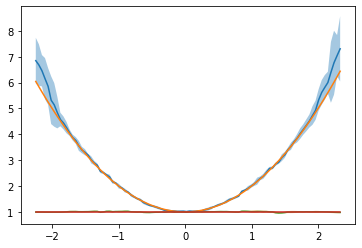

In [28]:
for t in range(n_outputs):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

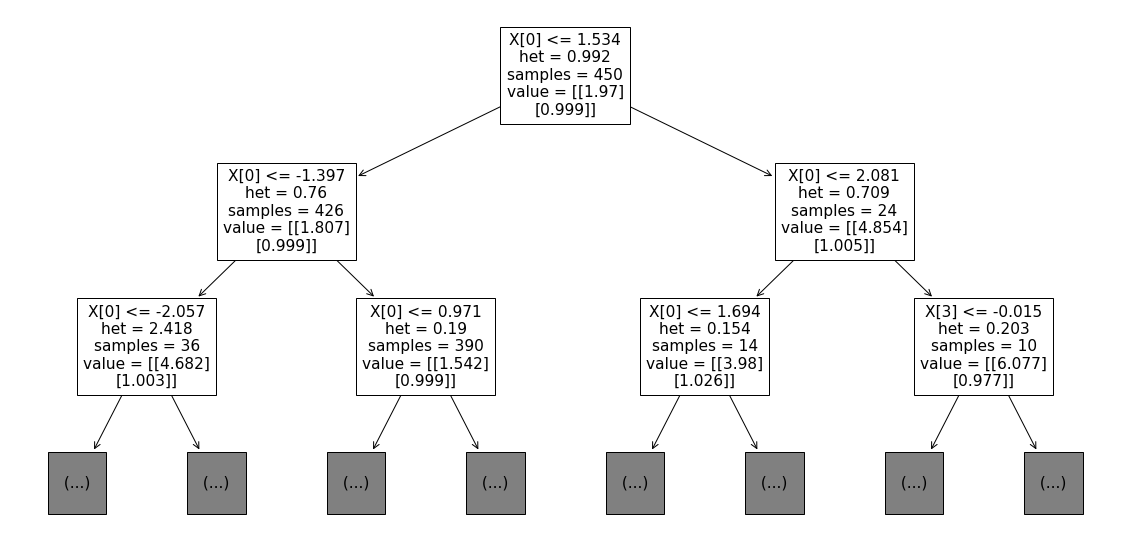

In [29]:
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

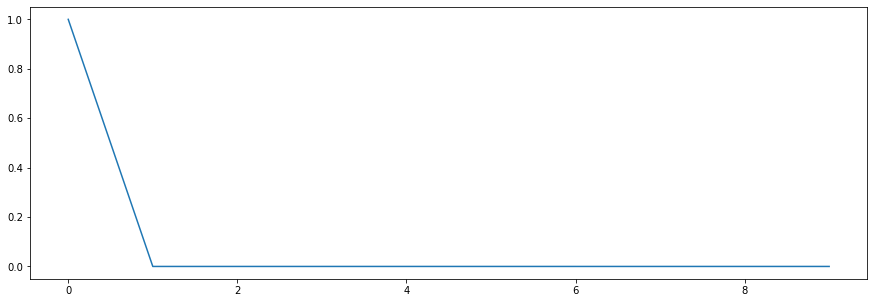

In [30]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

In [31]:
import shap
explainer = shap.Explainer(est, shap.maskers.Independent(X, max_samples=100))
shap_values = explainer(X[:200])

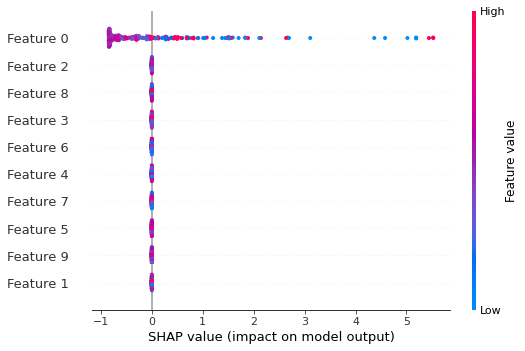

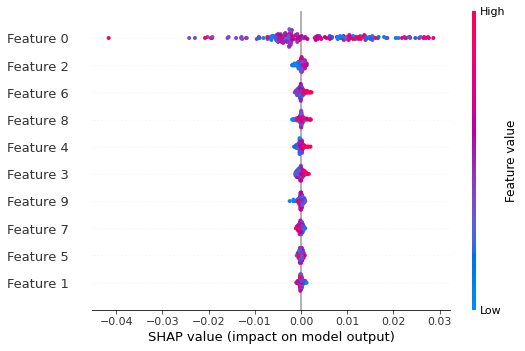

In [32]:
shap.plots.beeswarm(shap_values[:, :, 0])
shap.plots.beeswarm(shap_values[:, :, 1])

## 4. Combining with Double Machine Learning

In [33]:
np.random.seed(123)
n_samples = 5000
n_features = 10
n_treatments = 3
n_outputs = 2
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
def true_te(X):
    return np.hstack([(X[:, [0]] > 0) * X[:, [0]],
                      np.ones((X.shape[0], n_treatments - 1)) * np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
W = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 5.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
y = np.tile(y, (1, n_outputs))
for j in range(n_outputs):
    y[:, j] = (j + 1) * y[:, j]
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [34]:
est = CausalForestDML(cv=2,
                      criterion='mse', n_estimators=400,
                      min_var_fraction_leaf=0.1,
                      min_var_leaf_on_val=True,
                      verbose=0, discrete_treatment=False,
                      n_jobs=-1, random_state=123)
%time est.fit(y, T, X=X, W=W)

Wall time: 11.3 s


In [35]:
res = est.const_marginal_effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=.01)

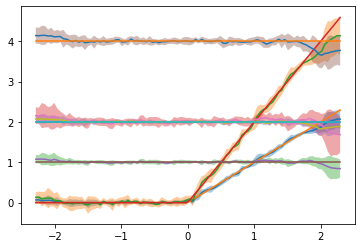

In [36]:
for t in range(n_treatments):
    for j in range(n_outputs):
        plt.plot(X_test[:, 0], point[:, j, t])
        plt.fill_between(X_test[:,0], lb[:, j, t], ub[:, j, t], alpha=.4)
        plt.plot(X_test[:, 0], (j + 1) * true_te(X_test)[:, t])
plt.show()

In [37]:
res.summary_frame()

point_estimate  stderr   zstat  pvalue  ci_lower  ci_upper
X  Y  T                                                             
0  Y0 T0           0.066   0.025   2.660   0.008     0.025     0.107
      T1           1.077   0.040  26.652   0.000     1.011     1.144
      T2           2.071   0.039  53.520   0.000     2.007     2.134
   Y1 T0           0.132   0.050   2.660   0.008     0.050     0.213
      T1           2.155   0.081  26.652   0.000     2.022     2.288
...                  ...     ...     ...     ...       ...       ...
99 Y0 T1           0.842   0.087   9.706   0.000     0.699     0.985
      T2           1.887   0.074  25.641   0.000     1.766     2.008
   Y1 T0           4.139   0.187  22.148   0.000     3.832     4.447
      T1           1.684   0.174   9.706   0.000     1.399     1.970
      T2           3.774   0.147  25.641   0.000     3.532     4.016

[600 rows x 6 columns]

In [38]:
res = est.effect_inference(X_test,
                           T0=np.zeros((X_test.shape[0], n_treatments)),
                           T1=np.ones((X_test.shape[0], n_treatments)))
point = res.point_estimate
lb, ub = res.conf_int(alpha=0.01)

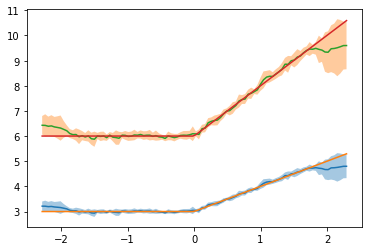

In [39]:
for j in range(n_outputs):
    plt.plot(X_test[:, 0], point[:, j])
    plt.fill_between(X_test[:,0], lb[:, j], ub[:, j], alpha=.4)
    plt.plot(X_test[:, 0], (j + 1) * np.sum(true_te(X_test), axis=1))
plt.show()

In [40]:
res.summary_frame()

point_estimate  stderr   zstat  pvalue  ci_lower  ci_upper
X  Y                                                             
0  Y0           3.214   0.072  44.951     0.0     3.097     3.332
   Y1           6.428   0.143  44.951     0.0     6.193     6.663
1  Y0           3.212   0.086  37.447     0.0     3.071     3.353
   Y1           6.424   0.172  37.447     0.0     6.142     6.706
2  Y0           3.194   0.074  43.012     0.0     3.072     3.317
...               ...     ...     ...     ...       ...       ...
97 Y1           9.551   0.413  23.151     0.0     8.872    10.229
98 Y0           4.798   0.185  25.954     0.0     4.494     5.102
   Y1           9.596   0.370  25.954     0.0     8.988    10.204
99 Y0           4.799   0.183  26.212     0.0     4.497     5.100
   Y1           9.597   0.366  26.212     0.0     8.995    10.199

[200 rows x 6 columns]

In [41]:
est.feature_importances_

array([[0.98217628, 0.00347145, 0.00153771, 0.00260605, 0.00102379,
        0.00138967, 0.00223861, 0.00133064, 0.0030675 , 0.00115831],
       [0.98217628, 0.00347145, 0.00153771, 0.00260605, 0.00102379,
        0.00138967, 0.00223861, 0.00133064, 0.0030675 , 0.00115831]])

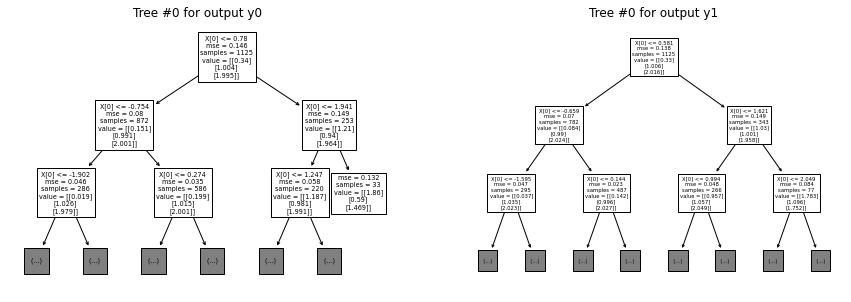

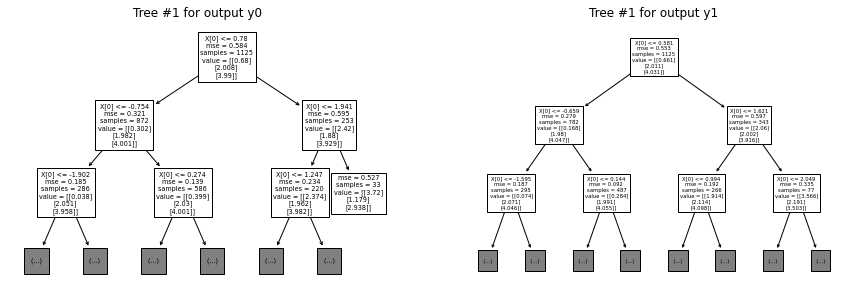

In [42]:
for tree_id, tree_per_output in enumerate(est[:2]):
    plt.figure(figsize=(15, 5))
    for j in range(n_outputs):
        plt.subplot(1, n_outputs, j + 1)
        plot_tree(tree_per_output[j], max_depth=2)
        plt.title("Tree #{} for output y{}".format(tree_id, j))
    plt.show()

In [43]:
est[0]

[GRFTree(max_features='auto', min_var_leaf=0.020617404788809485,
         min_var_leaf_on_val=True, random_state=914636141),
 GRFTree(max_features='auto', min_var_leaf=0.020617404788809485,
         min_var_leaf_on_val=True, random_state=914636141)]

In [44]:
import shap
shap_values = est.shap_values(X[:20])

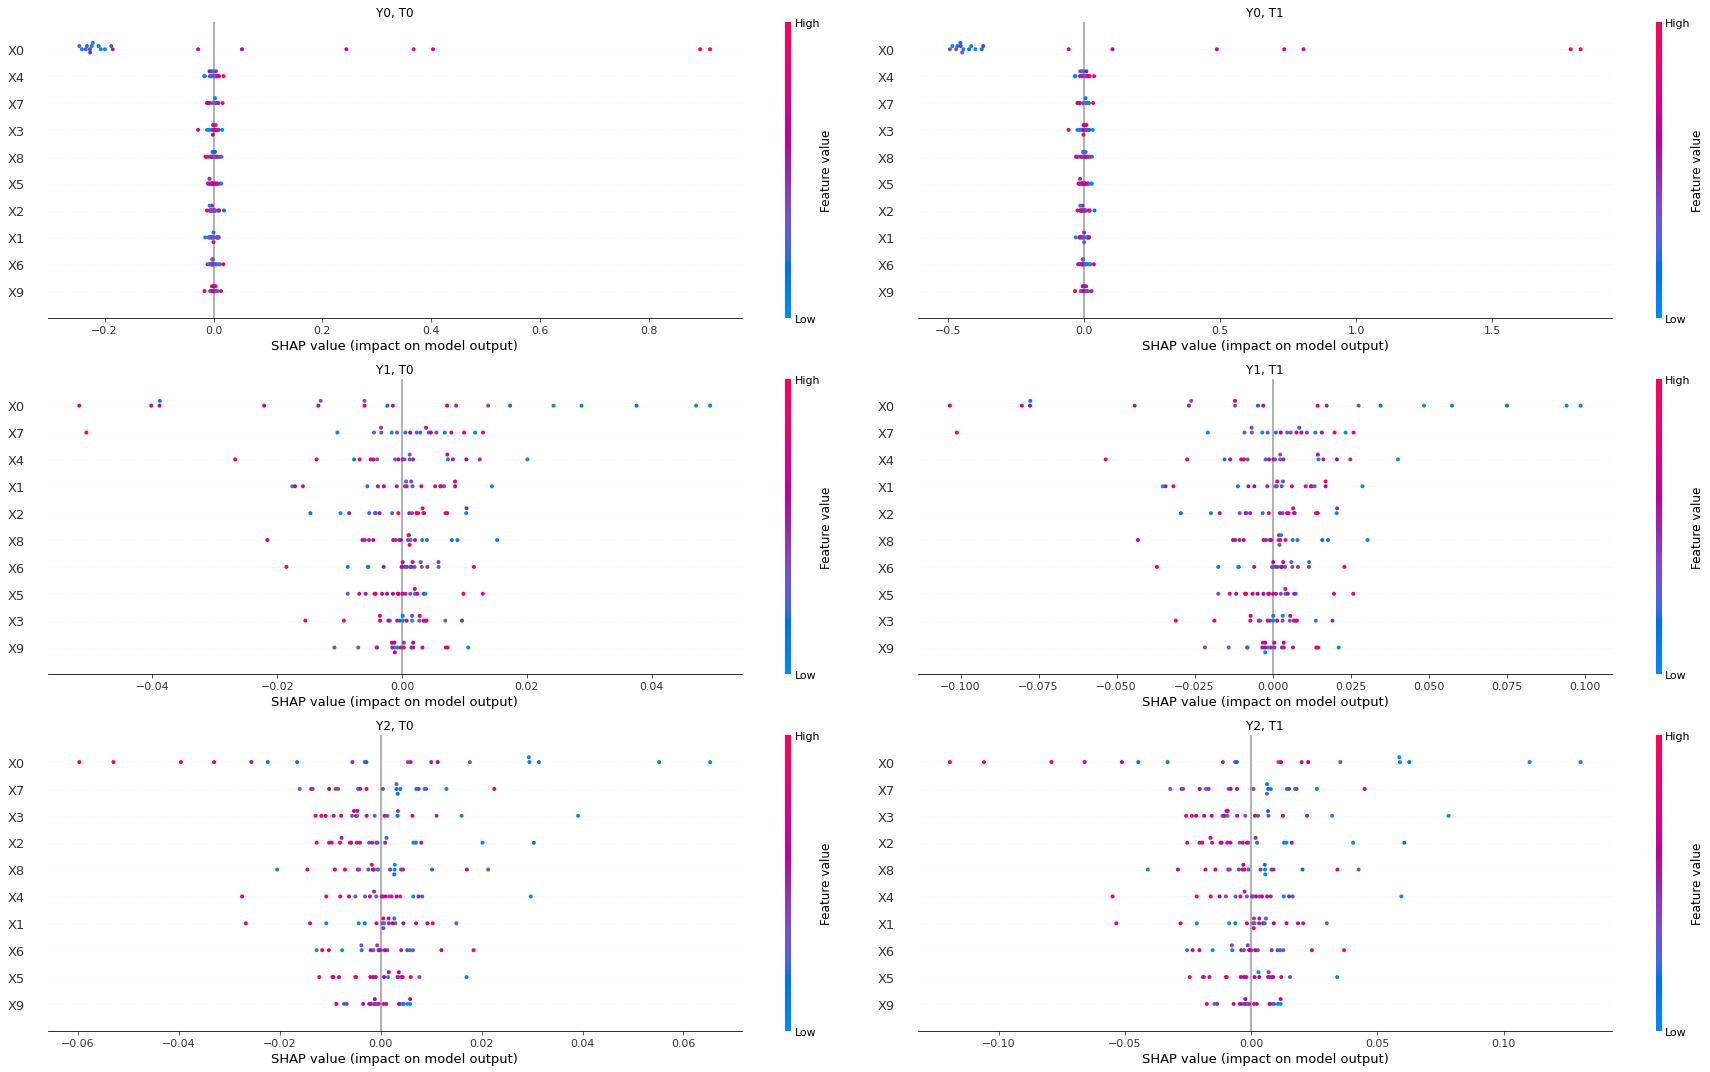

In [45]:
plt.figure(figsize=(25, 15))
for j in range(n_treatments):
    for i in range(n_outputs):
        plt.subplot(n_treatments, n_outputs, i + j * n_outputs + 1)
        plt.title("Y{}, T{}".format(j, i))
        shap.plots.beeswarm(shap_values['Y' + str(i)]['T' + str(j)], plot_size=None, show=False)
plt.tight_layout()
plt.show()

# 5. Custom Linear Moment Forest

We can even easily create an estimator class that solves a customer linear moment that we want to define on the fly. The `BaseGRF` class can handle the estimation of any linear moment problem of the form:
\begin{equation}
E[\text{pointJ} \cdot (\theta(x); \beta(x)) - \alpha \mid X=x] = 0
\end{equation}

The user simply needs to create a child class that inherits from the `BaseGRF` and implement the abstract methods `_get_alpha_and_pointJ` and `_get_n_outputs_decomposition`. The first function takes as input all the variables passed at fit time (i.e. `X`, `T`, `y`, and any other keyword based variables the user passes) and returns for each sample the $\alpha$ vector of the linear moment and a flattened version of the $\text{pointJ}$ matrix in the linear moment (in Fortran contiguous form, i.e. the first row is first, the second row next etc). The second function returns two numbers, the first number corresponds to the size of the concatenated parameter vector $(\theta(x); \beta(x))$ and the second number corresponds to the size of the prefix $\theta(x)$ that we care about ($\beta(x)$ is a nuisance parameter).

As a simple expository example let's see how we can create a forest that solves a moment of the form:
\begin{equation}
E[(y - \theta(x)' (T; T^2)) (Z; Z^2) \mid X=x]
\end{equation}
i.e. where we expand the treatments and instruments to include their squares and solve this quadratic in treatment heterogenous IV model.

In [46]:
np.random.seed(1227)
n_samples = 2000
n_features = 10
n_treatments = 2
def true_te(X):
    return np.hstack([X[:, [0]] > 0, np.ones((X.shape[0], n_treatments - 1))])
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10 * U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [47]:
from econml.grf._base_grf import BaseGRF
from econml.utilities import cross_product

class CustomGRF(BaseGRF):

    def _get_alpha_and_pointJ(self, X, T, y, *, Z):
        T = np.hstack([T, T**2])
        Z = np.hstack([Z, Z**2])
        if self.fit_intercept:
            T = np.hstack([T, np.ones((T.shape[0], 1))])
            Z = np.hstack([Z, np.ones((T.shape[0], 1))])
        return y * Z, cross_product(Z, T)


    def _get_n_outputs_decomposition(self, X, T, y, *, Z):
        n_relevant_outputs = T.shape[1] * 2
        n_outputs = n_relevant_outputs
        if self.fit_intercept:
            n_outputs += 1
        return n_outputs, n_relevant_outputs

In [48]:
est = CustomGRF(criterion='mse', n_estimators=400, min_samples_leaf=40,
                     min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
                     min_impurity_decrease = 0.001, max_samples=.45, max_depth=None,
                     warm_start=False, inference=True, subforest_size=4,
                     honest=True, verbose=0, n_jobs=-1, random_state=123)

In [49]:
est.fit(X, T, y, Z=Z)

CustomGRF(min_impurity_decrease=0.001, min_samples_leaf=40,
          min_var_fraction_leaf=0.1, min_var_leaf_on_val=True, n_estimators=400,
          random_state=123)

In [50]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

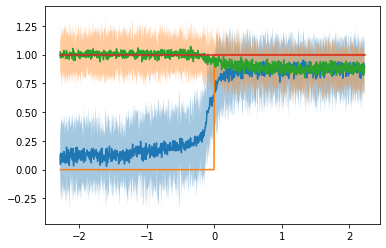

In [51]:
for t in range(n_outputs):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

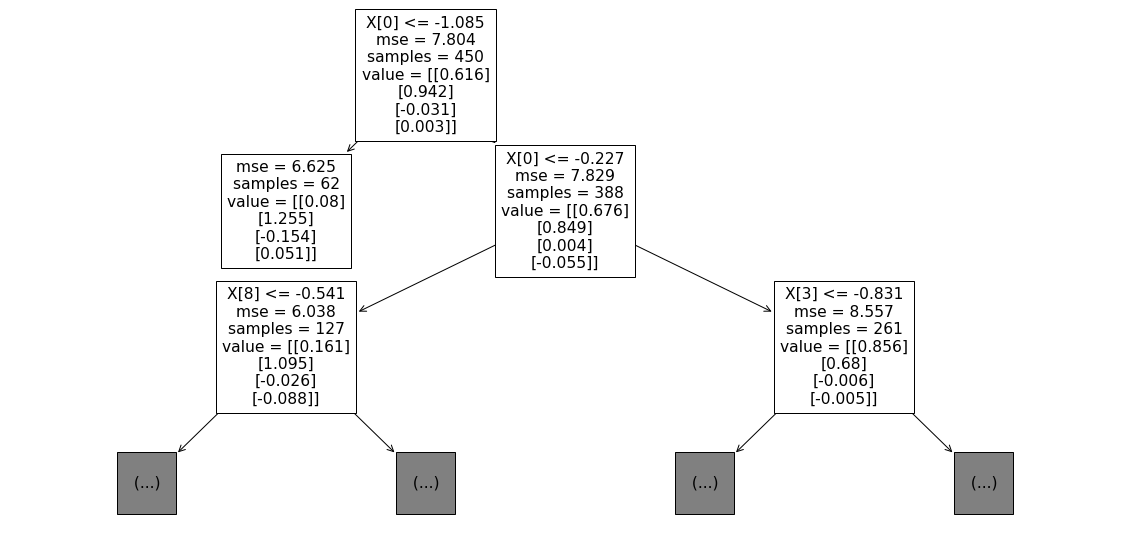

In [52]:
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

In [53]:
import shap
explainer = shap.Explainer(est, shap.maskers.Independent(X, max_samples=100))
shap_values = explainer(X[:200])

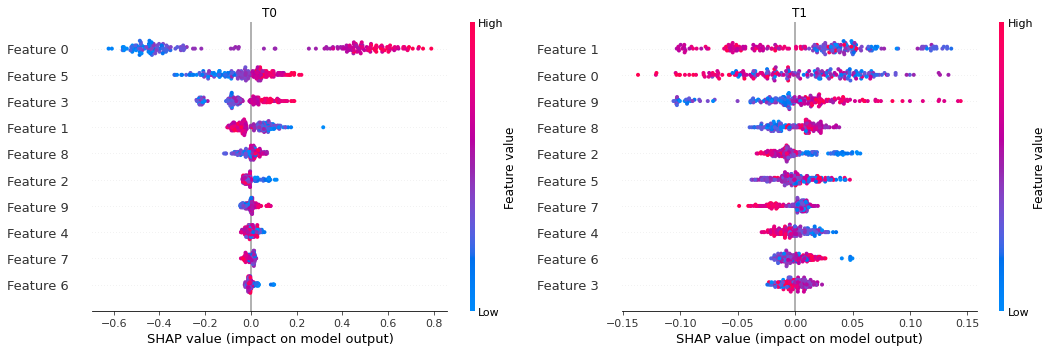

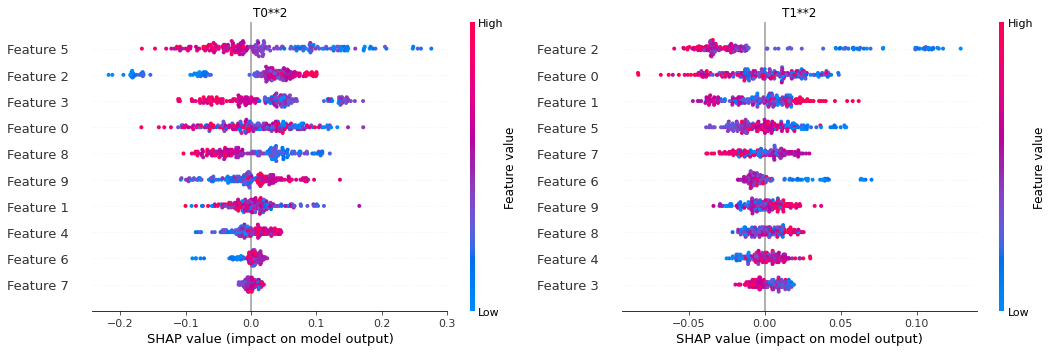

In [54]:
plt.figure(figsize=(15, 5))
for t in range(n_treatments):
    plt.subplot(1, n_treatments, t + 1)
    plt.title("T{}".format(t))
    shap.plots.beeswarm(shap_values[..., t], plot_size=None, show=False)
plt.tight_layout()
plt.show()
plt.figure(figsize=(15, 5))
for t in range(n_treatments):
    plt.subplot(1, n_treatments, t + 1)
    plt.title("T{}**2".format(t))
    shap.plots.beeswarm(shap_values[..., t + n_treatments], plot_size=None, show=False)
plt.tight_layout()
plt.show()